Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# AE sanity check

In [1]:
import os
from monai_utils.utils import define_instance
from monai_utils.diff_model_setting import load_config
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

trained_autoencoder_path_url = (
    "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/"
    "model_zoo/model_maisi_autoencoder_epoch273_alternative.pt"
)

work_dir = "./openmind_diffusion_training"
if not os.path.isdir(work_dir):
    raise(RuntimeError("Please set up training directory with the code below"))
    
env_config_filepath = os.path.join(work_dir, "environment_maisi_diff_model.json")
model_config_filepath = os.path.join(work_dir, "config_maisi_diff_model.json")
model_def_filepath = os.path.join(work_dir, "config_maisi.json")

trained_autoencoder_path = os.path.join(work_dir, "models/autoencoder_epoch273.pt")
if not os.path.exists(trained_autoencoder_path):
    download_url(url=trained_autoencoder_path_url, filepath=trained_autoencoder_path)

args = load_config(env_config_filepath, model_config_filepath, model_def_filepath)
autoencoder = define_instance(args, "autoencoder_def").to(device).half()
checkpoint_autoencoder = torch.load(trained_autoencoder_path, weights_only=True)
autoencoder.load_state_dict(checkpoint_autoencoder)
print(f"Successfully loaded autoencoder with {sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)} parameters")

/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-08 16:39:59.339816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-08 16:39:59.339888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-08 16:39:59.344597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-08 16:39:59.437809: I tensorflow/core/platform/cpu_feature_guard.cc:182]

Successfully loaded autoencoder with 20944897 parameters


Loading image from /home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-openmind_workspace/OpenMind/OpenMind/ds000001/sub-02/anat/sub-02_T1w.nii.gz


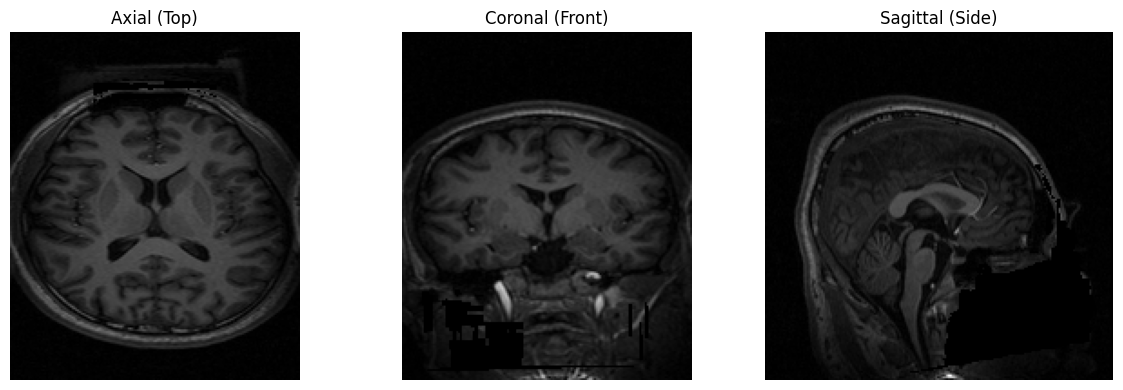

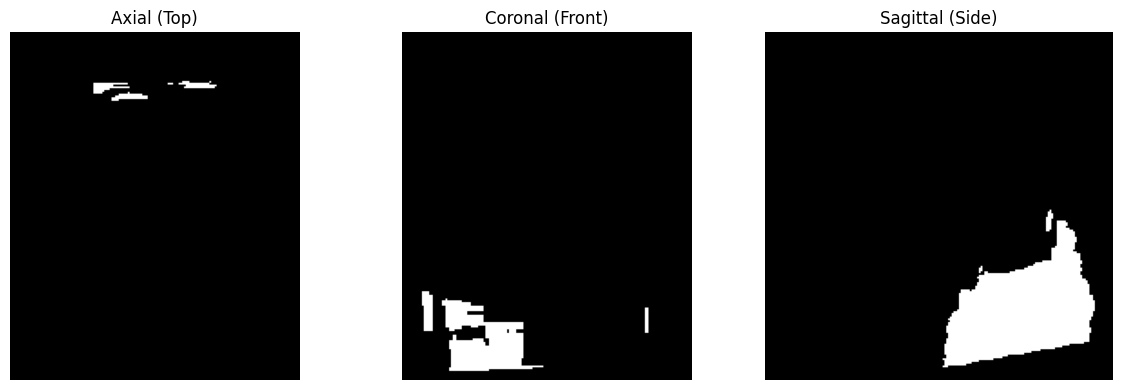

In [2]:
import pandas as pd
import monai
import matplotlib.pyplot as plt
import numpy as np

def visualize_orthogonal_views(volume):
    """
    Show axial (top), coronal (front), and sagittal (side) views
    from the center of a 3D MRI volume.

    Args:
        volume: 3D array-like (H, W, D) or 4D (C, H, W, D).
    """
    # Ensure numpy
    if isinstance(volume, torch.Tensor):
        volume = volume.detach().cpu().numpy()
    if volume.ndim == 4:  # remove channel if present
        volume = volume[0]

    # Shape: (H, W, D)
    h, w, d = volume.shape

    # Extract central slices
    axial = volume[:, :, d // 2]     # top view
    coronal = volume[:, w // 2, :]   # front view
    sagittal = volume[h // 2, :, :]  # side view

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(axial.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[0].set_title("Axial (Top)")
    axes[0].axis("off")

    axes[1].imshow(coronal.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[1].set_title("Coronal (Front)")
    axes[1].axis("off")

    axes[2].imshow(sagittal.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[2].set_title("Sagittal (Side)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


ds_dir = "/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-openmind_workspace/OpenMind/OpenMind"

metadata = pd.read_csv(os.path.join(ds_dir, "..", "openneuro_metadata.csv"))
metadata = metadata[metadata["modality"] == "T1w"]
test_image_path = os.path.join(ds_dir, metadata["image_path"].iloc[1])
anon_mask_path = os.path.join(ds_dir, metadata["anon_mask_path"].iloc[1])
print(f"Loading image from {test_image_path}")

load_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImage(),
        monai.transforms.EnsureChannelFirst(),
        monai.transforms.Orientation(axcodes="RAS"),
        monai.transforms.EnsureType(dtype=torch.float32),
        monai.transforms.ScaleIntensityRange(
            a_min=0, a_max=1300, b_min=0, b_max=1, clip=True
        )
    ]
)

test_image = load_transform(test_image_path)
anon_mask = monai.transforms.LoadImage()(anon_mask_path)
visualize_orthogonal_views(test_image)
visualize_orthogonal_views(anon_mask)

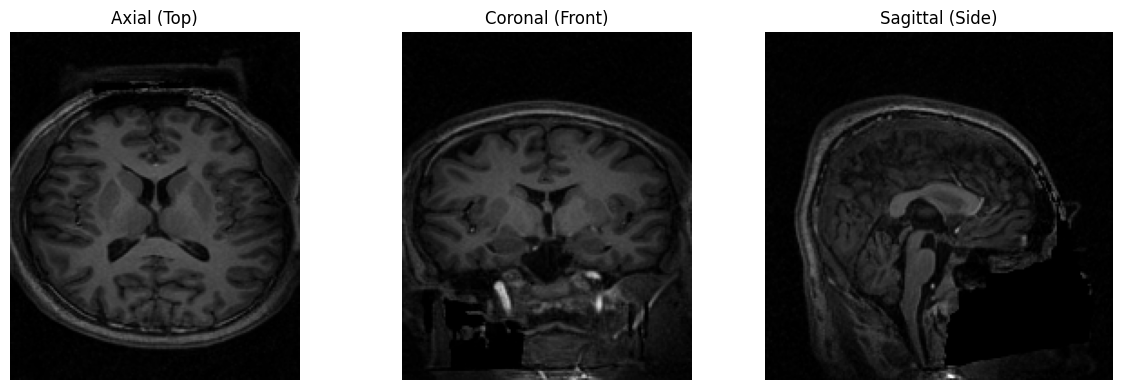

metatensor(-0.1065, device='cuda:0') metatensor(-4.8623, device='cuda:0') metatensor(5.0484, device='cuda:0') metatensor(0.9534, device='cuda:0')


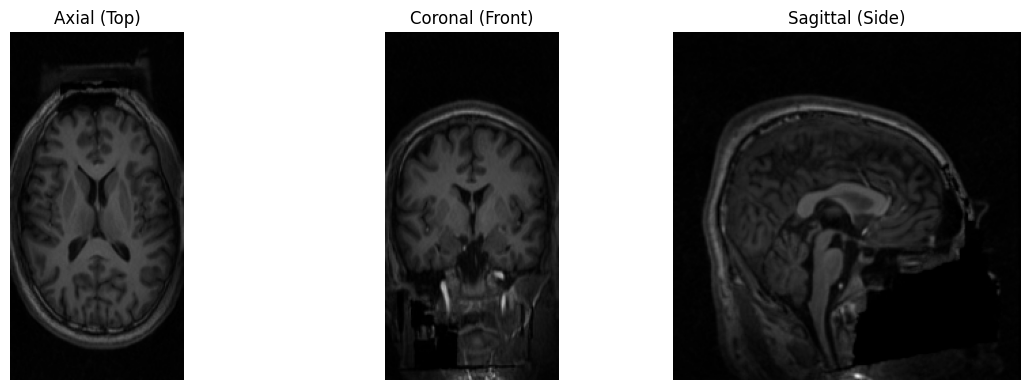

In [9]:
from monai.inferers.inferer import SlidingWindowInferer
from monai_utils.utils import dynamic_infer
from monai_utils.sample import ReconModel

with torch.no_grad():
    z = autoencoder.encode_stage_2_inputs(test_image.unsqueeze(0).to(device).half())

    val_inferer = SlidingWindowInferer(
            roi_size=[80, 80, 80],
            sw_batch_size=1,
            progress=True,
            mode="gaussian",
            overlap=0.4,
            sw_device=device,
            device=device,
        )

    autoencoder.eval()
    reconstructed_image = dynamic_infer(val_inferer, ReconModel(autoencoder, 1.0), z.half()).float()
    
    visualize_orthogonal_views(reconstructed_image.squeeze(0))
    load_transform = monai.transforms.Compose(
        [
            monai.transforms.LoadImage(),
            monai.transforms.EnsureChannelFirst(),
            monai.transforms.Orientation(axcodes="RAS")
        ]
    )
    precomputed_embedding = load_transform(test_image_path.replace(".nii.gz", "_emb.nii.gz").replace("ds00", "embeddings/ds00")).to(device).unsqueeze(0)
    print(precomputed_embedding.mean(), precomputed_embedding.min(), precomputed_embedding.max(), precomputed_embedding.std())
    reconstructed_image = dynamic_infer(val_inferer, ReconModel(autoencoder, 1.0), precomputed_embedding.half()).float()
    visualize_orthogonal_views(reconstructed_image.squeeze(0))


## Find maximum of MRI scans

In [6]:
from tqdm.auto import tqdm

n_images_to_load = 100
metadata = metadata[metadata["modality"] == "T1w"]
rand_ind = torch.randperm(len(metadata))[:n_images_to_load]

load_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImage(),
        monai.transforms.EnsureChannelFirst(),
        monai.transforms.Orientation(axcodes="RAS"),
        monai.transforms.EnsureType(dtype=torch.float32),
    ]
)


mins, maxs = [], []

for ind in tqdm(rand_ind):
    image_path = os.path.join(ds_dir, metadata["image_path"].iloc[0])
    im = load_transform(image_path)
    mins.append(im.min())
    maxs.append(im.max())

100%|██████████| 100/100 [00:07<00:00, 13.14it/s]


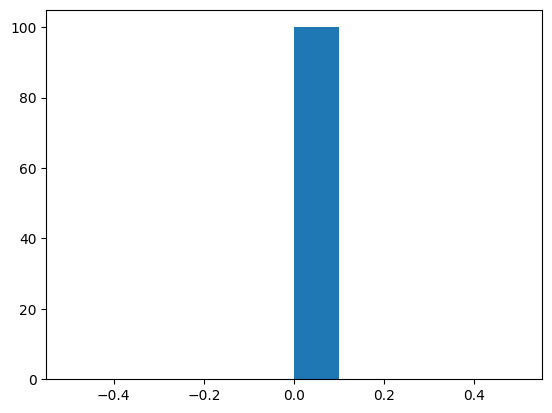

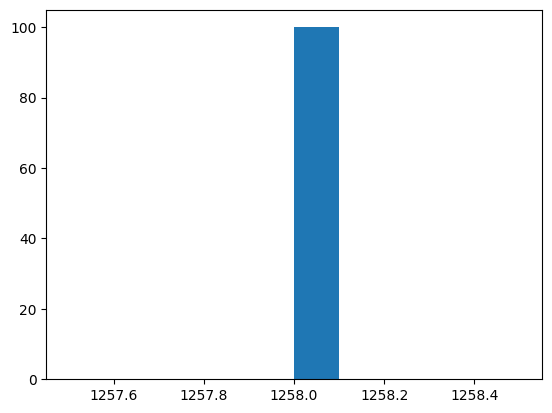

In [7]:
plt.hist(mins)
plt.show()

plt.hist(maxs)
plt.show()

## Check precomputed embedding

torch.Size([4, 32, 64, 64])


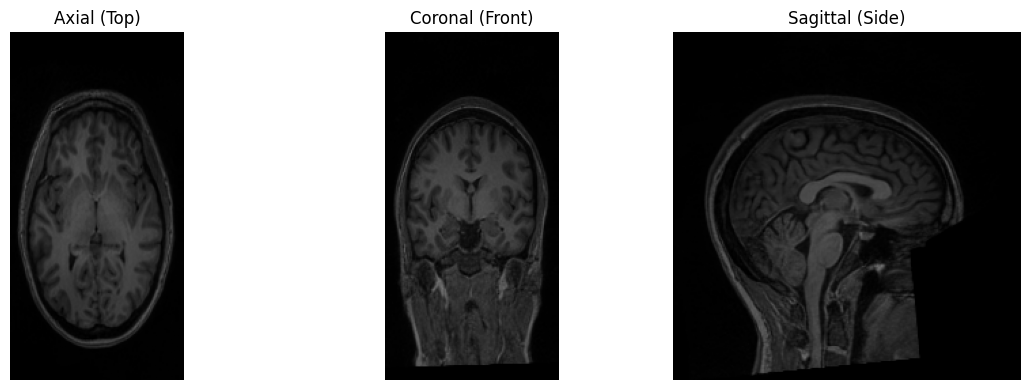

In [12]:
embedding_path = "/home/hd/hd_hd/hd_gu452/FFF_fiberlearning/notebooks/monai_models/openmind_diffusion_training/embeddings/ds000115/sub-39/anat/sub-39_T1w_emb.nii.gz"
emb = load_transform(embedding_path).to(device)
with torch.no_grad():
    reconstructed_image = dynamic_infer(val_inferer, ReconModel(autoencoder, 1.0), emb.unsqueeze(0).half()).float()
    visualize_orthogonal_views(reconstructed_image.squeeze(0))

# GPU Memory test for embedding

In [13]:
from monai_utils.diff_model_create_training_data import process_file, load_filenames, create_transforms, round_number
from monai_utils.diff_model_setting import initialize_distributed, load_config, setup_logging
from monai_utils.utils import define_instance
from pathlib import Path
import os
import torch
from math import prod

work_dir = "./openmind_diffusion_training"

env_config_filepath = os.path.join(work_dir, "environment_maisi_diff_model.json")
model_config_filepath = os.path.join(work_dir, "config_maisi_diff_model.json")
model_def_filepath = os.path.join(work_dir, "config_maisi.json")

@torch.inference_mode()
def test_inference(env_config_path: str, model_config_path: str, model_def_path: str, num_gpus: int):
    args = load_config(env_config_path, model_config_path, model_def_path)
    local_rank, world_size, device = initialize_distributed(num_gpus=num_gpus)
    logger = setup_logging("creating training data")
    logger.info(f"Using device {device}")
    
    autoencoder = define_instance(args, "autoencoder_def").to(device)
    try:
        checkpoint_autoencoder = torch.load(
            args.trained_autoencoder_path, weights_only=True
        )
        autoencoder.load_state_dict(checkpoint_autoencoder)
    except Exception:
        logger.error("The trained_autoencoder_path does not exist!")

    autoencoder = autoencoder.half()
    Path(args.embedding_base_dir).mkdir(parents=True, exist_ok=True)
    
    filenames_raw = load_filenames(args.json_data_list)
    # logger.info(f"filenames_raw: {filenames_raw}")
    
    plain_transforms = create_transforms(dim=None)
    
    for filepath in filenames_raw:
        out_filename_base = filepath.replace(".gz", "").replace(".nii", "")
        out_filename_base = os.path.join(args.embedding_base_dir, out_filename_base)
        out_filename = out_filename_base + "_emb.nii.gz"
        if not os.path.isfile(out_filename):
            break
        else:
            test_data = {"image": os.path.join(args.data_base_dir, filepath)}
            td = plain_transforms(test_data)  # load once
            dims = [int(td["image"].meta["dim"][i]) for i in range(1, 4)]
            print(tuple(round_number(d) for d in dims))
            del td
    
    test_data = {"image": os.path.join(args.data_base_dir, filepath)}
    td = plain_transforms(test_data)  # load once
    img = td["image"]
    dims = [int(img.meta["dim"][i]) for i in range(1, 4)]
    new_dim = tuple(round_number(d) for d in dims)
    if prod(new_dim) > 2e7:
        new_dim = tuple(d//2 for d in new_dim)
    new_transforms = create_transforms(new_dim)
    process_file(filepath, args, autoencoder, device, td, new_transforms, logger)
    torch.cuda.empty_cache()


test_inference(env_config_filepath, model_config_filepath, model_def_filepath, 1)

[2025-09-01 19:13:41.912][ INFO](creating training data) - Using device cuda:0


(128, 256, 256)
(256, 256, 256)
(256, 256, 256)
(128, 256, 256)
(128, 256, 256)
(256, 256, 256)
(256, 256, 128)
(256, 256, 128)
(256, 256, 128)
(128, 256, 256)
(128, 256, 256)
(128, 256, 256)
(256, 256, 256)
(128, 128, 128)
(256, 256, 256)
(128, 256, 256)
(128, 256, 256)
(128, 256, 256)


[2025-09-01 19:13:47.594][ INFO](creating training data) - old dim: [348, 576, 576], old spacing: [0.5000007152557373, 0.43689319491386414, 0.4368932247161865]
[2025-09-01 19:13:47.928][ INFO](creating training data) - new dim: (192, 256, 256), new affine: [[ 9.04554415e-01 -1.92405581e-02 -5.69660962e-02 -7.52866090e+01]
 [ 2.03717537e-02  9.81535211e-01  4.90759760e-02 -1.47205613e+02]
 [ 5.15534393e-02 -5.02645969e-02  9.80129868e-01 -1.08225152e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[2025-09-01 19:13:47.930][ INFO](creating training data) - out_filename: /home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-openmind_workspace/OpenMind/OpenMind/./embeddings/ds004889/sub-57/anat/sub-57_T1w_emb.nii.gz
[2025-09-01 19:13:49.568][ INFO](creating training data) - z: torch.Size([1, 4, 48, 64, 64]), torch.float32


# Check training data reconstructions

Training only with [{'image': 'ds000115/sub-97/anat/sub-97_T1w.nii.gz', 'deface_mask': 'ds000115/sub-97/anat/sub-97_T1w__Data/deface_mask.nii.gz'}, {'image': 'ds004169/sub-0173/ses-01/anat/sub-0173_ses-01_T1w.nii.gz', 'deface_mask': 'ds004169/sub-0173/ses-01/anat/sub-0173_ses-01_T1w__Data/deface_mask.nii.gz'}, {'image': 'ds004647/sub-0014/ses-1/anat/sub-0014_ses-1_run-1_T1w.nii.gz', 'deface_mask': 'ds004647/sub-0014/ses-1/anat/sub-0014_ses-1_run-1_T1w__Data/deface_mask.nii.gz'}]
/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-openmind_workspace/OpenMind/OpenMind/ds000115/sub-97/anat/sub-97_T1w__Data/deface_mask.nii.gz
torch.Size([1, 176, 256, 256])


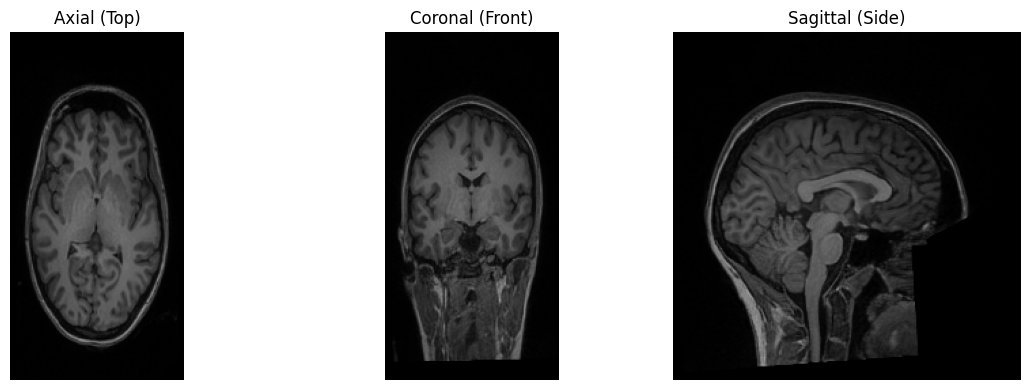

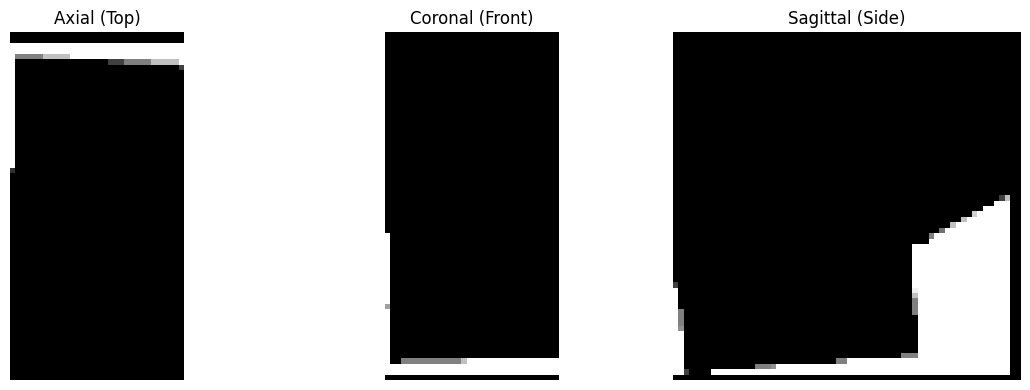

/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/monai/data/meta_tensor.py:495: UserWarning: Only 2d and 3d affine are supported, got 0d input.
  warnings.warn(f"Only 2d and 3d affine are supported, got {r}d input.")


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 4)

In [26]:
from monai_utils.diff_model_train import prepare_data, load_filenames
from monai.transforms import Resize
import monai
import matplotlib.pyplot as plt
import numpy as np
from monai.inferers.inferer import SlidingWindowInferer
from monai_utils.utils import dynamic_infer
from monai_utils.sample import ReconModel
import torch
import os
from monai_utils.utils import define_instance
from monai_utils.diff_model_setting import load_config
import json

device = "cuda" if torch.cuda.is_available() else "cpu"

def visualize_orthogonal_views(volume):
    """
    Show axial (top), coronal (front), and sagittal (side) views
    from the center of a 3D MRI volume.

    Args:
        volume: 3D array-like (H, W, D) or 4D (C, H, W, D).
    """
    # Ensure numpy
    if isinstance(volume, torch.Tensor):
        volume = volume.detach().cpu().numpy()
    if volume.ndim == 4:  # remove channel if present
        volume = volume[0]

    # Shape: (H, W, D)
    h, w, d = volume.shape

    # Extract central slices
    axial = volume[:, :, d // 2]     # top view
    coronal = volume[:, w // 2, :]   # front view
    sagittal = volume[h // 2, :, :]  # side view

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(axial.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[0].set_title("Axial (Top)")
    axes[0].axis("off")

    axes[1].imshow(coronal.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[1].set_title("Coronal (Front)")
    axes[1].axis("off")

    axes[2].imshow(sagittal.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[2].set_title("Sagittal (Side)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

work_dir = "./openmind_diffusion_training"

env_config_filepath = os.path.join(work_dir, "environment_maisi_diff_model.json")
model_config_filepath = os.path.join(work_dir, "config_maisi_diff_model.json")
model_def_filepath = os.path.join(work_dir, "config_maisi.json")

args = load_config(env_config_filepath, model_config_filepath, model_def_filepath)


filenames_train = load_filenames(args.json_data_list)

train_files = []
for _i in range(len(filenames_train)):
    str_img = os.path.join(args.embedding_base_dir, filenames_train[_i])
    if not os.path.exists(str_img):
        continue

    str_info = os.path.join(args.embedding_base_dir, filenames_train[_i]) + ".json"

    # The original JSON data list has deface_mask paths (relative to data root)
    with open(str_info, "r") as f:
        json_data = json.load(f)
    deface_mask_path = json_data["mask_path"]

    print(deface_mask_path)
    train_files_i = {
        "image": str_img,
        "mask": os.path.join(args.data_base_dir, deface_mask_path),
        "spacing": str_info,
    }
    
    train_files.append(train_files_i)
    break 
    
train_loader = prepare_data(
    train_files,
    device,
    args.diffusion_unet_train["cache_rate"],
    batch_size=args.diffusion_unet_train["batch_size"],
    include_body_region=False,
)

test_data = iter(train_loader).__next__()
test_emb = test_data["image"].to(device)
test_mask_small = test_data["mask"].to(device)


autoencoder = define_instance(args, "autoencoder_def").to(device).half()
trained_autoencoder_path = os.path.join(work_dir, "models/autoencoder_epoch273.pt")
checkpoint_autoencoder = torch.load(trained_autoencoder_path, weights_only=True)
autoencoder.load_state_dict(checkpoint_autoencoder)
autoencoder.eval()
autoencoder = autoencoder.half()
inferer = SlidingWindowInferer(
            roi_size=[192]*3,
            sw_batch_size=1,
            progress=False,
            mode="gaussian",
            overlap=0.16,
            device=torch.device("cpu"),
            sw_device=device,
        )

recon_model = ReconModel(autoencoder=autoencoder, scale_factor=1.0).to(
    device
)
with torch.no_grad():
	synthetic_images = dynamic_infer(inferer, recon_model, test_emb.half())
data = synthetic_images.squeeze().cpu().detach().numpy()
#a_min, a_max, b_min, b_max = 0, 1258, 0, 1
#data = (data - b_min) / (b_max - b_min) * (a_max - a_min) + a_min
#data = np.clip(data, a_min, a_max)
visualize_orthogonal_views(data)
visualize_orthogonal_views(test_mask_small.squeeze(0))

resize = Resize(spatial_size=data.shape[-3:], mode="trilinear")
visualize_orthogonal_views(resize(test_mask_small.squeeze(0)))



# Create missing deface masks

In [5]:
import os
import glob
import torch
import monai
import nibabel as nib
import numpy as np
from tqdm.auto import tqdm

# Define your MONAI transform
load_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImage(),
        monai.transforms.EnsureChannelFirst(),
        monai.transforms.Orientation(axcodes="RAS"),
        monai.transforms.EnsureType(dtype=torch.float32),
        monai.transforms.ScaleIntensityRange(
            a_min=0, a_max=1300, b_min=0, b_max=1, clip=True
        ),
    ]
)

def create_missing_masks(root_dir):
    # find all *_T1w.nii.gz files
    t1w_files = glob.glob(os.path.join(root_dir, "**", "*_T1w.nii.gz"), recursive=True)

    print("Finished lising t1w files. Creating masks")
    for t1w_file in tqdm(t1w_files):
        dirname = os.path.dirname(t1w_file)
        basename = os.path.basename(t1w_file)
        prefix = basename[:-len("_T1w.nii.gz")]

        data_folder = os.path.join(dirname, f"{prefix}_T1w__Data")
        mask_path = os.path.join(data_folder, "deface_mask.nii.gz")

        if os.path.isfile(mask_path):
            continue  # mask already exists

        # Load image with MONAI transform
        image = load_transform(t1w_file)

        # Create zero tensor mask of same shape (ignore channel dimension)
        mask_array = np.zeros(image.shape[1:], dtype=np.uint8)

        # Ensure folder exists
        os.makedirs(data_folder, exist_ok=True)

        # Save mask using nibabel
        # Use affine and header from the original image
        orig_img = nib.load(t1w_file)
        mask_nifti = nib.Nifti1Image(mask_array, affine=orig_img.affine, header=orig_img.header)
        nib.save(mask_nifti, mask_path)

        # print(f"Created missing mask: {mask_path}")


root = "/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-openmind_workspace/OpenMind/OpenMind"  # change this
create_missing_masks(root)


Finished lising t1w files. Creating masks


100%|██████████| 39603/39603 [13:43<00:00, 48.07it/s]  


In [6]:
import os
import glob

def find_missing_deface_masks(root_dir):
    missing = []

    # search recursively for all *_T1w.nii.gz files
    t1w_files = glob.glob(os.path.join(root_dir, "**", "*_T1w.nii.gz"), recursive=True)

    for t1w_file in t1w_files:
        dirname = os.path.dirname(t1w_file)
        basename = os.path.basename(t1w_file)

        # get prefix (strip "_T1w.nii.gz")
        prefix = basename[:-len("_T1w.nii.gz")]

        # expected data folder and mask path
        data_folder = os.path.join(dirname, f"{prefix}_T1w__Data")
        mask_path = os.path.join(data_folder, "deface_mask.nii.gz")

        # check if missing
        if not (os.path.isdir(data_folder) and os.path.isfile(mask_path)):
            missing.append(t1w_file)

    return missing


if __name__ == "__main__":
    root = "/path/to/search"  # change this
    missing_files = find_missing_deface_masks(root)
    
    print("Found {} T1w files missing deface masks:".format(len(missing_files)))
    for f in missing_files:
        print(f)


Found 0 T1w files missing deface masks:


# Load entire dataset

In [4]:
from monai_utils.diff_model_train import prepare_data, load_filenames
from monai.transforms import Resize
import monai
import matplotlib.pyplot as plt
import numpy as np
from monai.inferers.inferer import SlidingWindowInferer
from monai_utils.utils import dynamic_infer
from monai_utils.sample import ReconModel
import torch
import os
from monai_utils.utils import define_instance
from monai_utils.diff_model_setting import load_config
import json
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

work_dir = "./openmind_diffusion_training"

env_config_filepath = os.path.join(work_dir, "environment_maisi_diff_model.json")
model_config_filepath = os.path.join(work_dir, "config_maisi_diff_model.json")
model_def_filepath = os.path.join(work_dir, "config_maisi.json")

args = load_config(env_config_filepath, model_config_filepath, model_def_filepath)


filenames_train = load_filenames(args.json_data_list)

train_files = []
for _i in tqdm(range(len(filenames_train))):
    str_img = os.path.join(args.embedding_base_dir, filenames_train[_i])
    if not os.path.exists(str_img):
        continue

    str_info = os.path.join(args.embedding_base_dir, filenames_train[_i]) + ".json"

    # The original JSON data list has deface_mask paths (relative to data root)
    with open(str_info, "r") as f:
        json_data = json.load(f)
    deface_mask_path = json_data["mask_path"]

    train_files_i = {
        "image": str_img,
        "mask": os.path.join(args.data_base_dir, deface_mask_path),
        "spacing": str_info,
    }
    
    train_files.append(train_files_i)
    
train_loader = prepare_data(
    train_files,
    device,
    args.diffusion_unet_train["cache_rate"],
    batch_size=args.diffusion_unet_train["batch_size"],
    include_body_region=False,
)

import traceback

def debug_dataloader_with_files(dataloader, keys=("image", "mask")):
    """
    Iterate through a DataLoader. If a worker throws, stop and
    print the file paths for the failing batch.
    """
    dataset = dataloader.dataset

    it = iter(dataloader)
    for batch_idx in tqdm(range(len(dataloader))):
        try:
            batch = next(it)  # force worker to load
        except Exception as e:
            print(f"\n❌ Error in batch {batch_idx}: {type(e).__name__}: {e}")
            traceback.print_exc(limit=2)

            # Recover dataset indices belonging to this batch
            batch_start = batch_idx * dataloader.batch_size
            batch_end = min(batch_start + dataloader.batch_size, len(dataset))
            print("Candidate file entries for this failing batch:")
            for j in range(batch_start, batch_end):
                print(f"  idx {j}: {dataset.data[j]}")
            
debug_dataloader_with_files(train_loader)

100%|██████████| 25394/25394 [29:19<00:00, 14.43it/s]  


# Training a 3D Diffusion Model for Generating 3D Images with Various Sizes and Spacings

![Generated image examples](https://developer-blogs.nvidia.com/wp-content/uploads/2024/06/image3.png)

In this notebook, we detail the procedure for training a 3D latent diffusion model to generate high-dimensional 3D medical images. Due to the potential for out-of-memory issues on most GPUs when generating large images (e.g., those with dimensions of 512 x 512 x 512 or greater), we have structured the training process into two primary steps: 1) generating image embeddings and 2) training 3D latent diffusion models. The subsequent sections will demonstrate the entire process using a simulated dataset.

`[Release Note (March 2025)]:` We are excited to announce the new MAISI Version `'maisi3d-rflow'`. Compared with the previous version `'maisi3d-ddpm'`, it accelerated latent diffusion model inference by 33x. Please see the detailed difference in the following section.

## Setup imports

In [1]:
import copy
import os
import json
import numpy as np
import nibabel as nib
import subprocess
from IPython.display import Image, display

from monai.apps import download_url
from monai.data import create_test_image_3d
from monai.config import print_config

from monai_utils.diff_model_setting import setup_logging

print_config()

logger = setup_logging("notebook")

/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-29 10:44:22.808277: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-29 10:44:22.808372: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-29 10:44:22.814471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-29 10:44:22.908841: I tensorflow/core/platform/cpu_feature_guard.cc:182]

MONAI version: 1.5.0
Numpy version: 1.25.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /home/hd/hd_hd/<username>/miniconda3/envs/pytorch/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.1.0
Tensorboard version: 2.14.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: 1.6.2
psutil version: 5.9.0
pandas version: 2.0.2
einops version: 0.7.0
transformers version: 4.40.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.mo

## Set up the MAISI version

Choose between `'maisi3d-ddpm'` and `'maisi3d-rflow'`. The differences are:
- The maisi version `'maisi3d-ddpm'` uses basic noise scheduler DDPM. `'maisi3d-rflow'` uses Rectified Flow scheduler, can be 33 times faster during inference.
- The maisi version `'maisi3d-ddpm'` requires training images to be labeled with body regions (`"top_region_index"` and `"bottom_region_index"`), while `'maisi3d-rflow'` does not have such requirement. In other words, it is easier to prepare training data for `'maisi3d-rflow'`.
- For the released model weights, `'maisi3d-rflow'` can generate images with better quality for head region and small output volumes, and comparable quality for other cases compared with `'maisi3d-ddpm'`.

In [2]:
maisi_version = "maisi3d-rflow"
if maisi_version == "maisi3d-ddpm":
    model_def_path = "./configs/config_maisi3d-ddpm.json"
elif maisi_version == "maisi3d-rflow":
    model_def_path = "./configs/config_maisi3d-rflow.json"
else:
    raise ValueError(f"maisi_version has to be chosen from ['maisi3d-ddpm', 'maisi3d-rflow'], yet got {maisi_version}.")
with open(model_def_path, "r") as f:
    model_def = json.load(f)
include_body_region = model_def["include_body_region"]
logger.info(f"MAISI version is {maisi_version}, whether to use body_region is {include_body_region}")

[2025-09-29 10:44:27.943][ INFO](notebook) - MAISI version is maisi3d-rflow, whether to use body_region is False


### Simulate a special dataset

It is widely recognized that training AI models is a time-intensive process. In this instance, we will simulate a small dataset and conduct training over multiple epochs. While the performance may not reach optimal levels due to the abbreviated training duration, the entire pipeline will be completed within minutes.

`sim_datalist` provides the information of the simulated datasets. It lists 2 training images. The size of the dimension is defined by the `sim_dim`.

In [3]:
import pandas as pd
import torch
from math import ceil

train_frac = 0.8

ds_dir = "/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-openmind_workspace/OpenMind/OpenMind"

metadata = pd.read_csv(os.path.join(ds_dir, "..", "openneuro_metadata.csv"))
metadata = metadata[metadata["modality"] == "T1w"]
rand_ind = torch.randperm(len(metadata))
ind_train, ind_val = rand_ind[:ceil(len(metadata)*train_frac)], rand_ind[ceil(len(metadata)*train_frac):]


datalist = {"training": [{"image": im_path, "deface_mask": mask_path} for im_path, mask_path in zip(metadata["image_path"].iloc[ind_train], 
                                                                                                    metadata["anon_mask_path"].iloc[ind_train])],
            "validation": [{"image": im_path, "deface_mask": mask_path} for im_path, mask_path in zip(metadata["image_path"].iloc[ind_val], 
                                                                                                    metadata["anon_mask_path"].iloc[ind_val])]}

In [4]:
datalist["validation"][:2]

[{'image': 'ds003787/sub-wlsubj007/ses-anat/anat/sub-wlsubj007_ses-anat_acq-highres_run-02_T1w.nii.gz',
  'deface_mask': 'ds003787/sub-wlsubj007/ses-anat/anat/sub-wlsubj007_ses-anat_acq-highres_run-02_T1w__Data/deface_mask.nii.gz'},
 {'image': 'ds004965/sub-126BPCP021113/ses-1/anat/sub-126BPCP021113_ses-1_acq-mprage_T1w.nii.gz',
  'deface_mask': 'ds004965/sub-126BPCP021113/ses-1/anat/sub-126BPCP021113_ses-1_acq-mprage_T1w__Data/deface_mask.nii.gz'}]

### Generate simulated images

Now we can use MONAI `create_test_image_3d` and `nib.Nifti1Image` functions to generate the 3D simulated images under the `work_dir`.

In [5]:
work_dir = "./openmind_diffusion_training"
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

dataroot_dir = ds_dir
if not os.path.isdir(dataroot_dir):
    os.makedirs(dataroot_dir)

datalist_file = os.path.join(work_dir, "datalist.json")
with open(datalist_file, "w") as f:
    json.dump(datalist, f)

### Set up directories and configurations

To optimize the demonstration for time efficiency, we have adjusted the training epochs to 2. Additionally, we modified the `num_splits` parameter in [AutoencoderKlMaisi](https://github.com/Project-MONAI/MONAI/blob/dev/monai/apps/generation/maisi/networks/autoencoderkl_maisi.py#L881) from its default value of 16 to 4. This adjustment reduces the spatial splitting of feature maps in convolutions, which is particularly beneficial given the smaller input size. (This change helps convert convolutions to a for-loop based approach, thereby conserving GPU memory resources.)

In [31]:
env_config_path = "./configs/environment_maisi_diff_model.json"
model_config_path = "./configs/config_maisi_diff_model.json"

# Load environment configuration, model configuration and model definition
with open(env_config_path, "r") as f:
    env_config = json.load(f)

with open(model_config_path, "r") as f:
    model_config = json.load(f)

env_config_out = copy.deepcopy(env_config)
model_config_out = copy.deepcopy(model_config)
model_def_out = copy.deepcopy(model_def)

# Set up directories based on configurations
env_config_out["data_base_dir"] = dataroot_dir
env_config_out["embedding_base_dir"] = os.path.join(dataroot_dir, env_config_out["embedding_base_dir"])
env_config_out["json_data_list"] = datalist_file
env_config_out["model_dir"] = os.path.join(work_dir, env_config_out["model_dir"])
env_config_out["output_dir"] = os.path.join(work_dir, env_config_out["output_dir"])
trained_autoencoder_path = os.path.join(work_dir, "models/autoencoder_epoch273.pt")
env_config_out["trained_autoencoder_path"] = trained_autoencoder_path
trained_autoencoder_path_url = (
    "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/"
    "model_zoo/model_maisi_autoencoder_epoch273_alternative.pt"
)
if not os.path.exists(trained_autoencoder_path):
    download_url(url=trained_autoencoder_path_url, filepath=trained_autoencoder_path)

# Create necessary directories
os.makedirs(env_config_out["embedding_base_dir"], exist_ok=True)
os.makedirs(env_config_out["model_dir"], exist_ok=True)
os.makedirs(env_config_out["output_dir"], exist_ok=True)

env_config_filepath = os.path.join(work_dir, "environment_maisi_diff_model.json")
with open(env_config_filepath, "w") as f:
    json.dump(env_config_out, f, sort_keys=True, indent=4)

# Update model configuration for demo
max_epochs = 100
model_config_out["diffusion_unet_train"]["n_epochs"] = max_epochs
model_config_out["diffusion_unet_train"]["lr"] = 0.00005
model_config_out["diffusion_unet_inference"]["num_inference_steps"] = 300

model_config_filepath = os.path.join(work_dir, "config_maisi_diff_model.json")
with open(model_config_filepath, "w") as f:
    json.dump(model_config_out, f, sort_keys=True, indent=4)

# Update model definition for demo
model_def_out["autoencoder_def"]["num_splits"] = 2
model_def_out["diffusion_unet_def"]["in_channels"] = model_def["latent_channels"] + 1
model_def_out["noise_scheduler"]["use_timestep_transform"] = False

model_def_filepath = os.path.join(work_dir, "config_maisi.json")
with open(model_def_filepath, "w") as f:
    json.dump(model_def_out, f, sort_keys=True, indent=4)

# Print files and folders under work_dir
logger.info(f"files and folders under work_dir: {os.listdir(work_dir)}.")

# Adjust based on the number of GPUs you want to use
num_gpus = 1
logger.info(f"number of GPUs: {num_gpus}.")

[2025-09-29 12:09:08.671][ INFO](notebook) - files and folders under work_dir: ['embeddings', '.ipynb_checkpoints', 'models', 'predictions', 'config_maisi.json', 'datalist.json', 'config_maisi_diff_model.json', 'environment_maisi_diff_model.json'].
[2025-09-29 12:09:08.672][ INFO](notebook) - number of GPUs: 1.


In [32]:
import sys

def run_torchrun(module, module_args, num_gpus=1):
    # Define the arguments for torchrun
    num_nodes = 1

    # Build the torchrun command
    torchrun_command = [
        f"{sys.executable}",
        "-m", "torch.distributed.run",
        "--nproc_per_node",
        str(num_gpus),
        "--nnodes",
        str(num_nodes),
        "-m",
        module,
    ] + module_args

    # Set the OMP_NUM_THREADS environment variable
    env = os.environ.copy()
    env["OMP_NUM_THREADS"] = "1"

    # Execute the command
    process = subprocess.Popen(torchrun_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)

    # Print the output in real-time
    try:
        while True:
            output = process.stdout.readline()
            if output == "" and process.poll() is not None:
                break
            if output:
                print(output.strip())
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        # Capture and print any remaining output
        stdout, stderr = process.communicate()
        print(stdout)
        if stderr:
            print(stderr)
    return

## Step 1: Create Training Data

To train the latent diffusion model, we first store the latent features produced by the autoencoder's encoder in local storage. This allows the latent diffusion model to directly utilize these features, thereby conserving both time and GPU memory during the training process. Additionally, we have provided the script for multi-GPU processing to save latent features from all training images, significantly accelerating the creation of the entire training set.

The diffusion model utilizes a U-shaped convolutional neural network architecture, requiring matching input and output dimensions. Therefore, it is advisable to resample the input image dimensions to be multiples of 2 for compatibility. In this case, we have chosen dimensions that are multiples of 128.

In [10]:
logger.info("Creating training data...")

# Define the arguments for torchrun
module = "monai_utils.diff_model_create_training_data"
module_args = [
    "--env_config",
    env_config_filepath,
    "--model_config",
    model_config_filepath,
    "--model_def",
    model_def_filepath,
    "--num_gpus",
    str(num_gpus),
]

run_torchrun(module, module_args, num_gpus=num_gpus)

[2025-08-26 18:10:42.991][ INFO](notebook) - Creating training data...



2025-08-26 18:11:01.430705: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-26 18:11:01.430749: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-26 18:11:01.430786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-26 18:11:01.437495: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-26 18:11:01.437525: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register 

KeyboardInterrupt: 

### Create .json files for embedding files

The diffusion model necessitates additional input attributes, including output dimension, output spacing, and top/bottom body region. These dimensions and spacing can be extracted from the header information of the training images. The top and bottom body region inputs can be determined through manual examination or by utilizing segmentation masks from tools such as [TotalSegmentator](https://github.com/wasserth/TotalSegmentator) or [MONAI VISTA](https://github.com/Project-MONAI/VISTA). The body regions are formatted as 4-dimensional one-hot vectors: the head and neck region is represented by [1,0,0,0], the chest region by [0,1,0,0], the abdomen region by [0,0,1,0], and the lower body region (below the abdomen) by [0,0,0,1]. The additional input attributes are saved in a separate .json file. In the following example, we assume that the images cover the chest and abdomen regions.

In [25]:
from tqdm.auto import tqdm

def list_gz_files(folder_path):
    """List all .gz files in the folder and its subfolders."""
    gz_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".gz"):
                gz_files.append(os.path.join(root, file))
    return gz_files


def create_json_files(gz_files, folder_path):
    """Create .json files for each .gz file with the specified keys and values."""
    for gz_file in tqdm(gz_files):
        # Load the NIfTI image
        json_filename = gz_file + ".json"
        # if os.path.exists(json_filename):
        #     continue
        img = nib.load(gz_file)

        # Get the dimensions and spacing
        dimensions = img.shape
        dimensions = dimensions[:3]
        spacing = img.header.get_zooms()[:3]
        spacing = spacing[:3]
        spacing = [float(_item) for _item in spacing]

        emb_rel_path = gz_file[len(folder_path)+1:]
        mask_rel_path = emb_rel_path[:-len("_emb.nii.gz")] + "__Data/deface_mask.nii.gz"
        mask_path = os.path.join(args.data_base_dir, mask_rel_path)
        # Create the dictionary with the specified keys and values
        data = {"dim": dimensions, "spacing": spacing, "mask_path": mask_path}
        if include_body_region:
            # The region can be selected from one of four regions from top to bottom.
            # [1,0,0,0] is the head and neck, [0,1,0,0] is the chest region, [0,0,1,0]
            # is the abdomen region, and [0,0,0,1] is the lower body region.
            data["top_region_index"] = [1, 0, 0, 0]  # chest region
            data["bottom_region_index"] = [1, 0, 0, 0]  # abdomen region
        # logger.info(f"data: {data}.")

        # Create the .json filename
        json_filename = gz_file + ".json"

        # Write the dictionary to the .json file
        with open(json_filename, "w") as json_file:
            json.dump(data, json_file, indent=4)
        # logger.info(f"Save json file to {json_filename}")


folder_path = env_config_out["embedding_base_dir"]
gz_files = list_gz_files(folder_path)
create_json_files(gz_files, folder_path)

logger.info("Completed creating .json files for all embedding files.")

  0%|          | 41/34681 [00:00<06:09, 93.73it/s]Traceback (most recent call last):
  File "/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self.

## Step 2: Train the Model

After all latent features have been created, we will initiate the multi-GPU script to train the latent diffusion model.

The image generation process utilizes the [DDPM scheduler](https://arxiv.org/pdf/2006.11239) with 1,000 iterative steps. The diffusion model is optimized using L1 loss and a decayed learning rate scheduler. The batch size for this process is set to 1.

Please be aware that using the H100 GPU may occasionally result in random segmentation faults. To avoid this issue, you can disable AMP by setting the `--no_amp` flag.

In [25]:
logger.info("Training the model...")

# Define the arguments for torchrun
module = "monai_utils.diff_model_train"
module_args = [
    "--env_config", 
    env_config_filepath,
    "--model_config",
    model_config_filepath,
    "--model_def",
    model_def_filepath,
    "--num_gpus",
    str(num_gpus),
]

run_torchrun(module, module_args, num_gpus=num_gpus)

[2025-09-02 14:06:04.467][ INFO](notebook) - Training the model...


Training only with [{'image': 'ds004471/sub-128/anat/sub-128_run-01_T1w.nii.gz', 'deface_mask': 'ds004471/sub-128/anat/sub-128_run-01_T1w__Data/deface_mask.nii.gz'}, {'image': 'ds004128/sub-OXTFCM/anat/sub-OXTFCM_T1w.nii.gz', 'deface_mask': 'ds004128/sub-OXTFCM/anat/sub-OXTFCM_T1w__Data/deface_mask.nii.gz'}]



KeyboardInterrupt



## Step 3: Infer using the Trained Model

Upon completing the training of the latent diffusion model, we can employ the multi-GPU script to perform inference. By integrating the diffusion model with the autoencoder's decoder, this process will generate 3D images with specified top/bottom body regions, spacing, and dimensions.

In [33]:
logger.info("Running inference...")

# Define the arguments for torchrun
module = "monai_utils.diff_model_infer"
module_args = [
    "--env_config",
    env_config_filepath,
    "--model_config",
    model_config_filepath,
    "--model_def",
    model_def_filepath,
    "--num_gpus",
    str(num_gpus),
]

run_torchrun(module, module_args, num_gpus=num_gpus)

logger.info("Completed all steps.")

[2025-09-29 12:09:16.060][ INFO](notebook) - Running inference...


tensor([1000.0000,  996.5000,  993.5000,  990.0000,  986.5000,  983.5000,
980.0000,  976.5000,  973.5000,  970.0000,  966.5000,  963.5000,
960.0000,  956.5000,  953.5000,  950.0000,  946.5000,  943.5000,
940.0000,  936.5000,  933.5000,  930.0000,  926.5000,  923.5000,
920.0000,  916.5000,  913.5000,  910.0000,  906.5000,  903.5000,
900.0000,  896.5000,  893.5000,  890.0000,  886.5000,  883.5000,
880.0000,  876.5000,  873.5000,  870.0000,  866.5000,  863.5000,
860.0000,  856.5000,  853.5000,  850.0000,  846.5000,  843.5000,
840.0000,  836.5000,  833.5000,  830.0000,  826.5000,  823.5000,
820.0000,  816.5000,  813.5000,  810.0000,  806.5000,  803.5000,
800.0000,  796.5000,  793.5000,  790.0000,  786.5000,  783.5000,
780.0000,  776.5000,  773.5000,  770.0000,  766.5000,  763.5000,
760.0000,  756.5000,  753.5000,  750.0000,  746.5000,  743.5000,
740.0000,  736.5000,  733.5000,  730.0000,  726.5000,  723.5000,
720.0000,  716.5000,  713.5000,  710.0000,  706.5000,  703.5000,
700.0000,  696.5

[2025-09-29 12:09:44.221][ INFO](notebook) - Completed all steps.



2025-09-29 12:09:22.131188: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-29 12:09:22.131235: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-29 12:09:22.131262: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-29 12:09:22.138735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-29 12:09:23.036372: W tensorflow/compiler

Upon completing the full training with the actual CT datasets, users can expect output images similar to the examples below, which present the generated images in axial, sagittal, and coronal views. The specific content may vary depending on the distribution of body regions in the training set. It is advisable to use tools such as [ITK-SNAP](http://www.itksnap.org/pmwiki/pmwiki.php) or [3D Slicer](https://www.slicer.org/) to visualize the entire volume for a comprehensive evaluation, rather than relying solely on the three different views to assess the quality of the checkpoints.

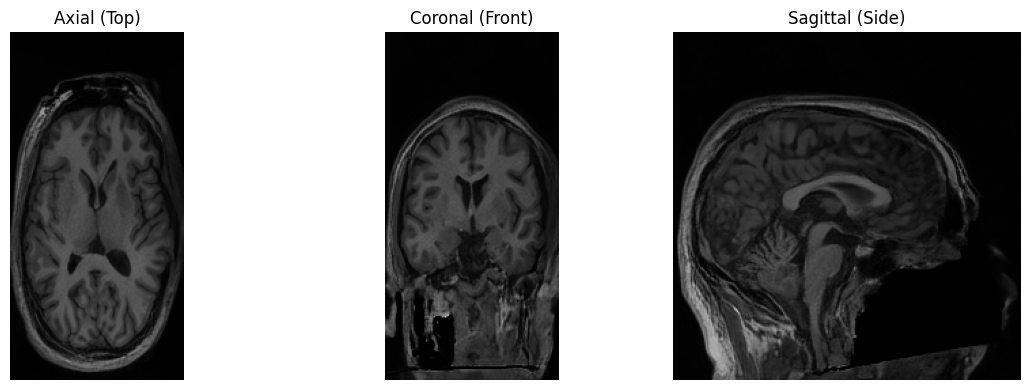

In [34]:
import pandas as pd
import monai
import matplotlib.pyplot as plt
import numpy as np
from monai.inferers.inferer import SlidingWindowInferer
from monai_utils.utils import dynamic_infer
from monai_utils.sample import ReconModel
import torch
import os
from monai_utils.utils import define_instance
from monai_utils.diff_model_setting import load_config

device = "cuda" if torch.cuda.is_available() else "cpu"


def visualize_orthogonal_views(volume):
    """
    Show axial (top), coronal (front), and sagittal (side) views
    from the center of a 3D MRI volume.

    Args:
        volume: 3D array-like (H, W, D) or 4D (C, H, W, D).
    """
    # Ensure numpy
    if isinstance(volume, torch.Tensor):
        volume = volume.detach().cpu().numpy()
    if volume.ndim == 4:  # remove channel if present
        volume = volume[0]

    # Shape: (H, W, D)
    h, w, d = volume.shape

    # Extract central slices
    axial = volume[:, :, d // 2]     # top view
    coronal = volume[:, w // 2, :]   # front view
    sagittal = volume[h // 2, :, :]  # side view

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(axial.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[0].set_title("Axial (Top)")
    axes[0].axis("off")

    axes[1].imshow(coronal.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[1].set_title("Coronal (Front)")
    axes[1].axis("off")

    axes[2].imshow(sagittal.T, cmap="gray", origin="lower", vmin=0, vmax=1)
    axes[2].set_title("Sagittal (Side)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

sample_path = "./openmind_diffusion_training/./predictions/unet_3d_seed50851_size128x256x256_spacing1.25x1.00x1.00_20250929120942_rank0.nii.gz"

load_transform = monai.transforms.Compose(
    [
        monai.transforms.LoadImage(),
        monai.transforms.EnsureChannelFirst(),
        monai.transforms.Orientation(axcodes="RAS"),
        monai.transforms.EnsureType(dtype=torch.float32),
        monai.transforms.ScaleIntensityRange(
            a_min=0, a_max=1258, b_min=0, b_max=1, clip=False
            # a_min=-1000, a_max=1000, b_min=0, b_max=1, clip=True
        )
    ]
)

sample = load_transform(sample_path)


visualize_orthogonal_views(sample.squeeze(0))

In [30]:
from monai_utils.diff_model_setting import load_config

args = load_config("openmind_diffusion_training/environment_maisi_diff_model.json", "openmind_diffusion_training/config_maisi_diff_model.json", "openmind_diffusion_training/config_maisi.json")
print(args)

Namespace(data_base_dir='/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-openmind_workspace/OpenMind/OpenMind', embedding_base_dir='/home/hd/hd_hd/hd_gu452/workspaces/gpfs/hd_gu452-openmind_workspace/OpenMind/OpenMind/./embeddings', existing_ckpt_filepath=None, json_data_list='./openmind_diffusion_training/datalist.json', model_dir='./openmind_diffusion_training/./models', model_filename='diff_unet_ckpt.pt', output_dir='./openmind_diffusion_training/./predictions', output_prefix='unet_3d', trained_autoencoder_path='./openmind_diffusion_training/models/autoencoder_epoch273.pt', diffusion_unet_inference={'bottom_region_index': [0, 0, 1, 0], 'dim': [128, 256, 256], 'modality': 1, 'num_inference_steps': 300, 'random_seed': 0, 'spacing': [1.25, 1.0, 1.0], 'top_region_index': [0, 1, 0, 0], 'use_timestep_transform': False}, diffusion_unet_train={'batch_size': 1, 'cache_rate': 0, 'lr': 5e-05, 'n_epochs': 100}, autoencoder_def={'_target_': 'monai.apps.generation.maisi.networks.autoencoderkl_ma

In [17]:
from monai_utils.utils import define_instance

noise_scheduler = define_instance(args, "noise_scheduler")

In [19]:
noise_scheduler.__dict__

{'prediction_type': v_prediction,
 'num_train_timesteps': 1000,
 'use_discrete_timesteps': False,
 'base_img_size_numel': 32768,
 'spatial_dim': 3,
 'sample_method': 'logit-normal',
 'distribution': LogisticNormal(),
 'sample_t': <function monai.networks.schedulers.rectified_flow.RFlowScheduler.__init__.<locals>.<lambda>(x)>,
 'use_timestep_transform': True,
 'transform_scale': 1.0,
 'steps_offset': 0}